In [121]:
# load package
import pandas as pd
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error #均方误差
from sklearn.metrics import mean_absolute_error #平方绝对误差
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
import scipy
import math
import geopandas as gp

In [122]:
# feature importance 特征重要性
def feture_importance(features, indices, importances):

    print("%%%%%% feature importances %%%%%%")

    '''
    for i in indices:
        print(features[i], importances[i])
    '''

    plt.barh(range(len(indices)), importances[indices], color='b', align='center', alpha=0.5)
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('feature Importance')
    plt.show()


# 评价指标
def evaluation(real_y, prediction_y):

    # rmse  mae  r2  r
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(real_y, prediction_y)
    print("R-squared", r_value**2)
    print("R", r_value)

    mae = mean_absolute_error(real_y, prediction_y)
    print("mae", mae)

    rmse = mean_squared_error(real_y, prediction_y) ** 0.5
    print("rmse", rmse)

    ############# 设置图例并且设置图例的字体及大小 #############
    font1 = {'family': 'Times New Roman',
            'weight': 'normal',
            'size': 15,
            }
    
    figsize = 20,16
    figure, ax = plt.subplots(figsize=figsize)
    level = [50000, 5500, 1000, 200, 100, 80, 60, 40,20]
    for i in range(len(level)):

        plt.subplot(3,3,i+1)
        plt.scatter(real_y, prediction_y, c='b', marker='o', label='', s=10, alpha=0.7, zorder=20)
        plt.plot([0, 50000], [0, 50000], '--', color='black', label='', linewidth=1.0)
        
        ############# 设置坐标刻度值的大小以及刻度值的字体 #############
        plt.xlim(0, level[i])
        plt.ylim(0, level[i])
        plt.tick_params(labelsize=15)
        
        plt.ylabel('prediction', font1)
        plt.xlabel('real', font1)

        # x，y轴设置显示刻度一致
        ax = plt.gca()
        ax.set_aspect(1)
    
    plt.show()


# 疫情建模
def covid_all_predict(df, index, threshold):
    
    '''
    df = df[['id','location',
    'rhMean','rhMax','rhMin',
    't2mMean','t2mMax','t2mMin',
    'moveInMean','moveInMax','moveInMin',
    'moveOutMea','moveOutMax','moveOutMin',
    'travelMean','travelMax','travelMin',
    'WuhanMean','WuhanMax','WuhanMin',
    'confirmed','confirmLog','npp']]
    '''
    
    df = df[['id','location',
    'rhMean',
    't2mMean',
    'moveInMean',
    'moveOutMea',
    'travelMean',
    'WuhanMean',
    'confirmed','confirmLog']]

    real_y = []
    prediction_y = []

    df_predict = []

    case = []

    clf = []
    for i in range(len(index)):
        clf.append(RandomForestRegressor(n_estimators=10, min_samples_split=5, max_depth=5))
    

    for i in range(len(index)):

        train_df = df.iloc[index[i][0], :]
        test_df = df.iloc[index[i][1], :]

        df_predict.extend(test_df['id'].to_list())

        train_y_log = train_df['confirmLog']
        train_y = train_df['confirmed']

        train_x = train_df.drop(['id', 'location', 'confirmLog', 'confirmed'], axis=1)

        test_y = test_df['confirmed']
        test_x = test_df.drop(['id', 'location', 'confirmLog', 'confirmed'], axis=1)

        clf[i].fit(train_x, train_y_log)

        predict_ytrain_log = clf[i].predict(train_x)
        predict_ytrain = np.trunc(np.exp(predict_ytrain_log) - 1)

        predict_ytest_log = clf[i].predict(test_x)
        predict_ytest = np.trunc(np.exp(predict_ytest_log) - 1)

        real_y.extend(test_y)
        prediction_y.extend(predict_ytest)

        print("train fold " + str(i+1))
        print("预测误差较大城市，绝对值误差阈值设置为" + str(threshold))
        predict_train_y = list(predict_ytrain)
        train_yy = train_y.to_list()
        for j in range(len(train_df)):
            if abs(train_yy[j]-predict_train_y[j])>threshold:
                print(train_df.iloc[j, 1] + "   real: " + str(train_yy[j]) + "   pre:" + str(predict_train_y[j]))
                #case.append(train_df.iloc[j, 0])

        evaluation(train_y, predict_ytrain)

        print("#########################################")
        print("test fold " + str(i+1))
        print("预测误差较大城市，绝对值误差阈值设置为" + str(threshold))
        predict_test_y = list(predict_ytest)
        test_yy = test_y.to_list()
        for j in range(len(test_df)):
            if abs(test_yy[j]-predict_test_y[j])>threshold:
                print(test_df.iloc[j, 1] + "   real: " + str(test_yy[j]) + "   pre:" + str(predict_test_y[j]))
                case.append(test_df.iloc[j, 0])

        evaluation(test_y, predict_ytest)
    

    df_predict = pd.DataFrame(df_predict)
    df_predict.columns = ['id']
    df_predict['predict'] = prediction_y

    print("************* cv evaluation ***************")
    evaluation(real_y, prediction_y)

    # feature importance
    train_y = df['confirmLog']
    train_x = df.drop(['id', 'location', 'confirmLog', 'confirmed'], axis=1)

    clf = RandomForestRegressor(n_estimators=10, min_samples_split=5, max_depth=5)
    clf.fit(train_x, train_y)

    features = list(train_x)
    importances = clf.feature_importances_
    indices = np.argsort(importances)
    feture_importance(features, indices, importances)

    return case, df_predict

In [123]:
# 所有城市全时间段建模

train fold 1
预测误差较大城市，绝对值误差阈值设置为50
北京市   real: 580   pre:451.0
天津市   real: 174   pre:79.0
哈尔滨市   real: 198   pre:123.0
上海市   real: 516   pre:382.0
宁波市   real: 157   pre:74.0
温州市   real: 504   pre:178.0
蚌埠市   real: 160   pre:27.0
南昌市   real: 230   pre:166.0
新余市   real: 130   pre:15.0
上饶市   real: 123   pre:54.0
济宁市   real: 260   pre:49.0
郑州市   real: 157   pre:279.0
十堰市   real: 672   pre:881.0
宜昌市   real: 931   pre:1152.0
襄阳市   real: 1175   pre:1023.0
鄂州市   real: 1394   pre:1126.0
荆州市   real: 1580   pre:1055.0
仙桃市   real: 575   pre:793.0
潜江市   real: 198   pre:328.0
珠海市   real: 103   pre:52.0
重庆市   real: 579   pre:401.0
甘孜藏族自治州   real: 78   pre:5.0
R-squared 0.9045269639763969
R 0.9510662248110785
mae 22.770833333333332
rmse 60.174087723316035


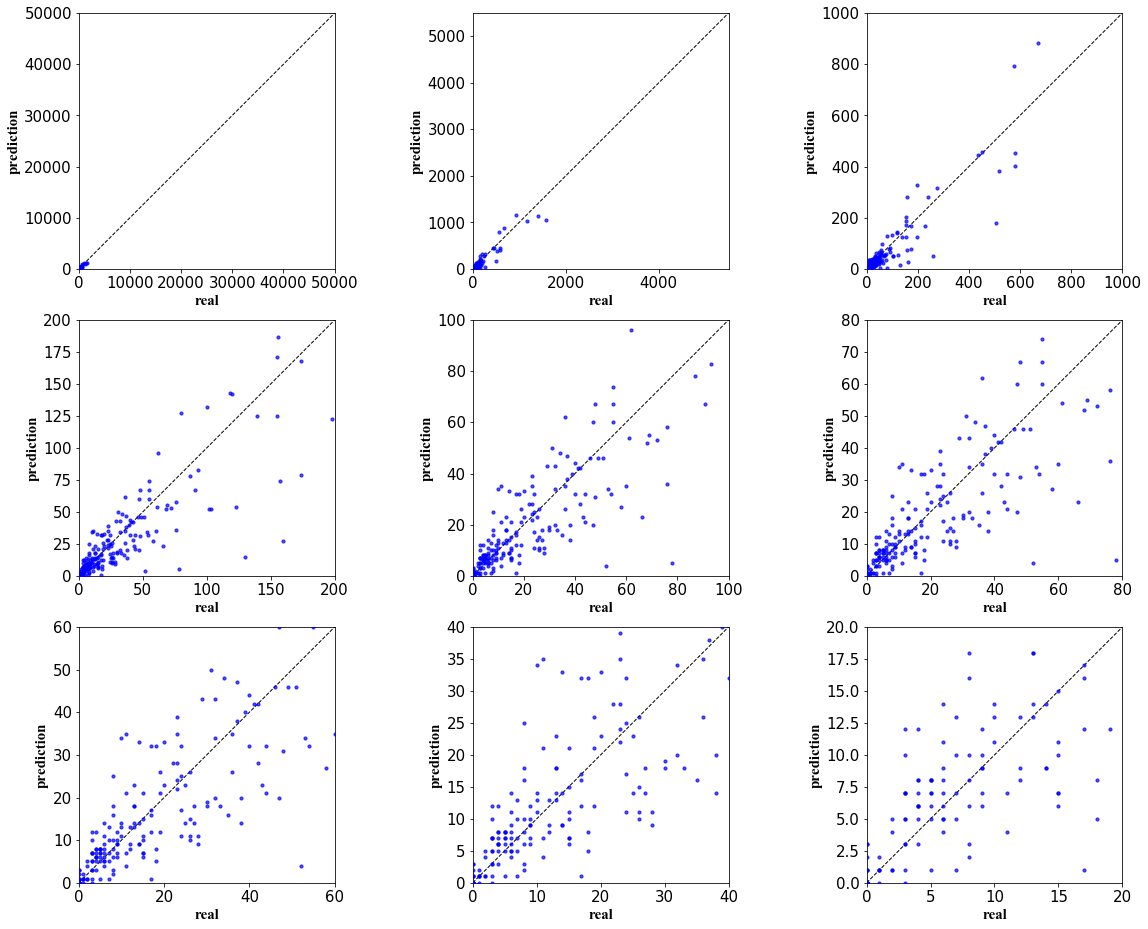

#########################################
test fold 1
预测误差较大城市，绝对值误差阈值设置为50
杭州市   real: 181   pre:99.0
台州市   real: 146   pre:45.0
亳州市   real: 108   pre:32.0
宜春市   real: 106   pre:48.0
武汉市   real: 50006   pre:845.0
黄石市   real: 1015   pre:861.0
荆门市   real: 928   pre:861.0
孝感市   real: 3518   pre:1055.0
黄冈市   real: 2907   pre:1055.0
咸宁市   real: 836   pre:1126.0
随州市   real: 1307   pre:588.0
恩施土家族苗族自治州   real: 252   pre:1152.0
天门市   real: 496   pre:370.0
R-squared 0.13488818230330354
R 0.3672712652839908
mae 470.92561983471074
rmse 4479.337076468805


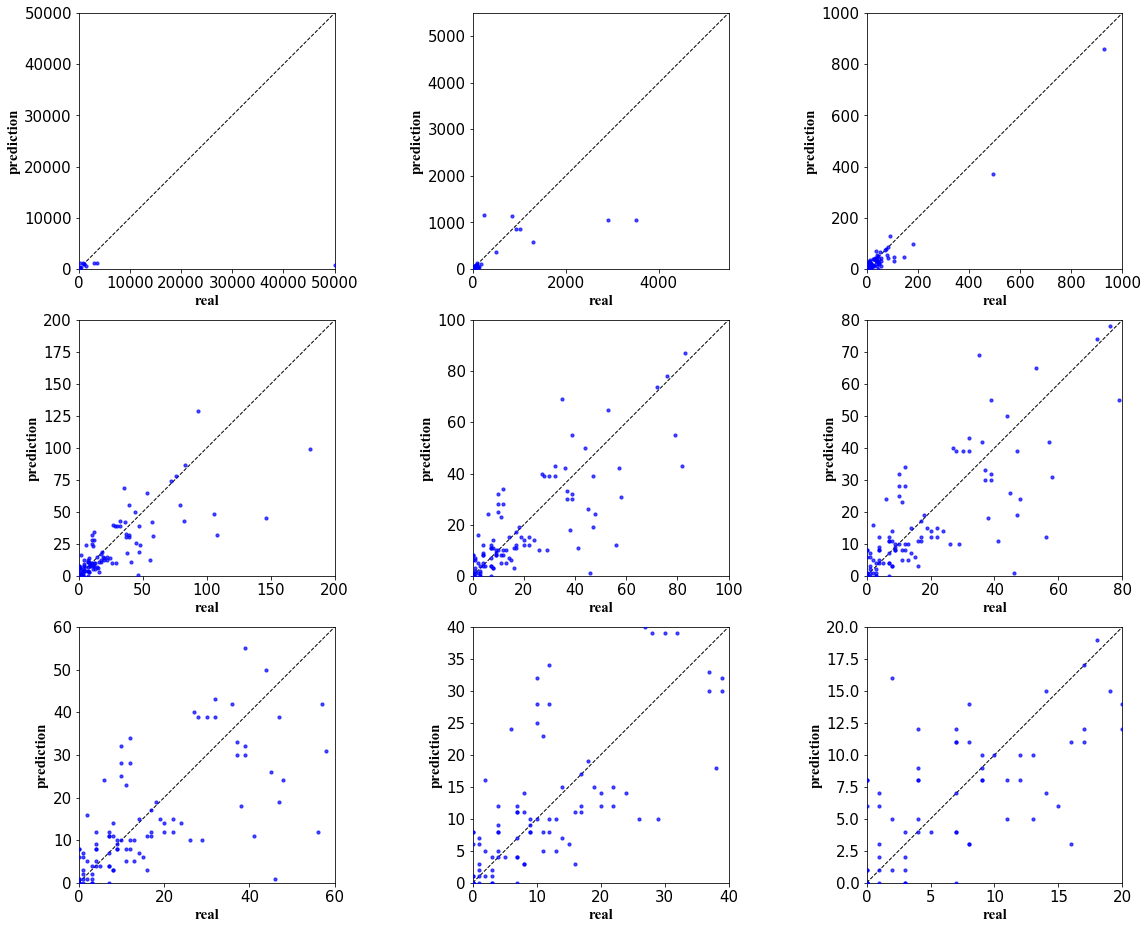

train fold 2
预测误差较大城市，绝对值误差阈值设置为50
北京市   real: 580   pre:502.0
杭州市   real: 181   pre:121.0
宁波市   real: 157   pre:81.0
台州市   real: 146   pre:74.0
亳州市   real: 108   pre:53.0
新余市   real: 130   pre:12.0
武汉市   real: 50006   pre:13413.0
黄石市   real: 1015   pre:838.0
宜昌市   real: 931   pre:787.0
鄂州市   real: 1394   pre:1625.0
荆门市   real: 928   pre:753.0
孝感市   real: 3518   pre:2209.0
荆州市   real: 1580   pre:1492.0
黄冈市   real: 2907   pre:2209.0
咸宁市   real: 836   pre:1093.0
随州市   real: 1307   pre:784.0
恩施土家族苗族自治州   real: 252   pre:565.0
天门市   real: 496   pre:583.0
广州市   real: 435   pre:195.0
深圳市   real: 450   pre:537.0
重庆市   real: 579   pre:505.0
甘孜藏族自治州   real: 78   pre:14.0
R-squared 0.9566081388825618
R 0.9780634636272647
mae 179.1908713692946
rmse 2359.7431193271054


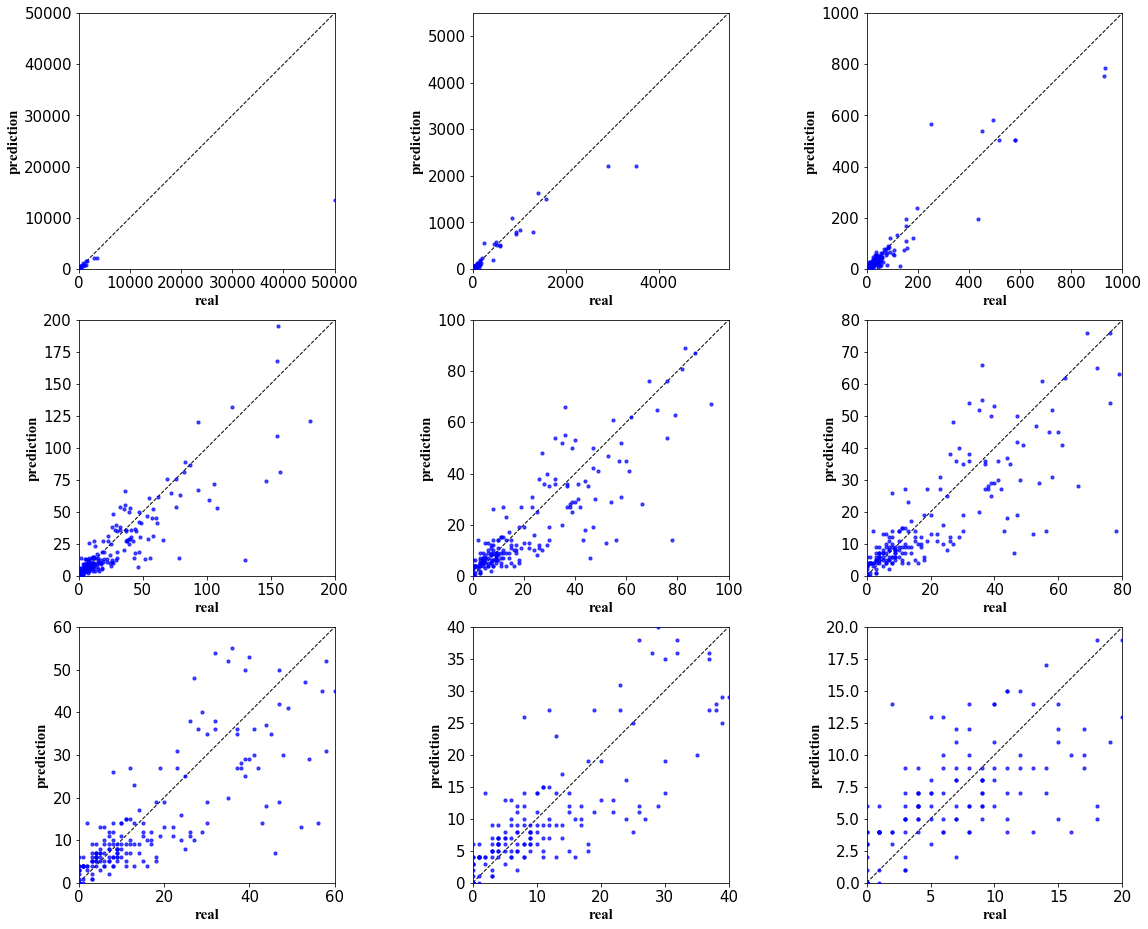

#########################################
test fold 2
预测误差较大城市，绝对值误差阈值设置为50
天津市   real: 174   pre:52.0
哈尔滨市   real: 198   pre:42.0
温州市   real: 504   pre:73.0
蚌埠市   real: 160   pre:11.0
南昌市   real: 230   pre:145.0
九江市   real: 118   pre:173.0
上饶市   real: 123   pre:45.0
济宁市   real: 260   pre:34.0
郑州市   real: 157   pre:437.0
信阳市   real: 274   pre:411.0
十堰市   real: 672   pre:784.0
襄阳市   real: 1175   pre:787.0
仙桃市   real: 575   pre:784.0
长沙市   real: 242   pre:483.0
株洲市   real: 80   pre:132.0
岳阳市   real: 156   pre:207.0
珠海市   real: 103   pre:46.0
R-squared 0.7294539127851214
R 0.8540807413735082
mae 32.90833333333333
rmse 76.92859243046979


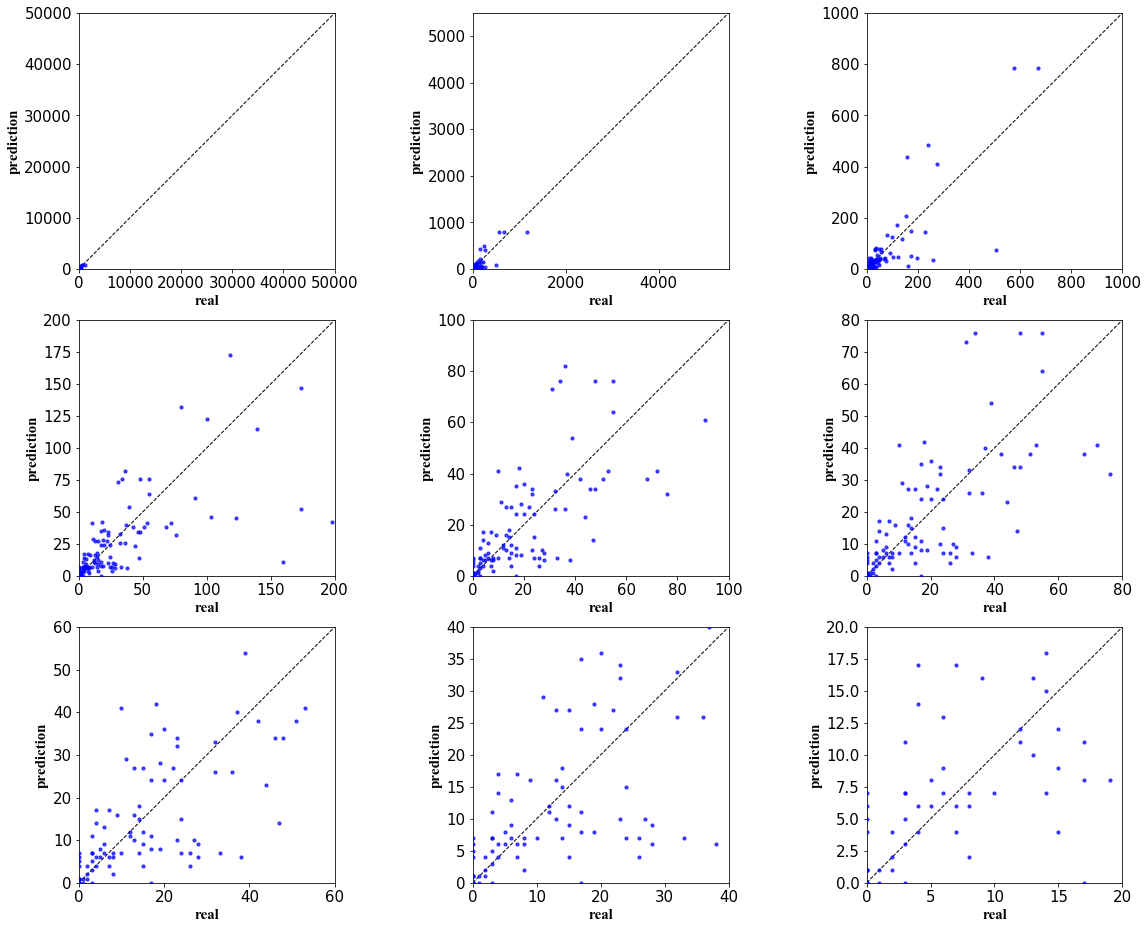

train fold 3
预测误差较大城市，绝对值误差阈值设置为50
天津市   real: 174   pre:110.0
哈尔滨市   real: 198   pre:112.0
温州市   real: 504   pre:221.0
台州市   real: 146   pre:61.0
蚌埠市   real: 160   pre:35.0
亳州市   real: 108   pre:36.0
上饶市   real: 123   pre:53.0
济宁市   real: 260   pre:61.0
信阳市   real: 274   pre:164.0
武汉市   real: 50006   pre:11237.0
黄石市   real: 1015   pre:1273.0
十堰市   real: 672   pre:821.0
襄阳市   real: 1175   pre:943.0
荆门市   real: 928   pre:848.0
孝感市   real: 3518   pre:3239.0
黄冈市   real: 2907   pre:1879.0
咸宁市   real: 836   pre:1233.0
恩施土家族苗族自治州   real: 252   pre:650.0
仙桃市   real: 575   pre:1031.0
天门市   real: 496   pre:781.0
东莞市   real: 100   pre:204.0
R-squared 0.9123648548689667
R 0.9551779179131847
mae 188.39834024896265
rmse 2499.0868855265494


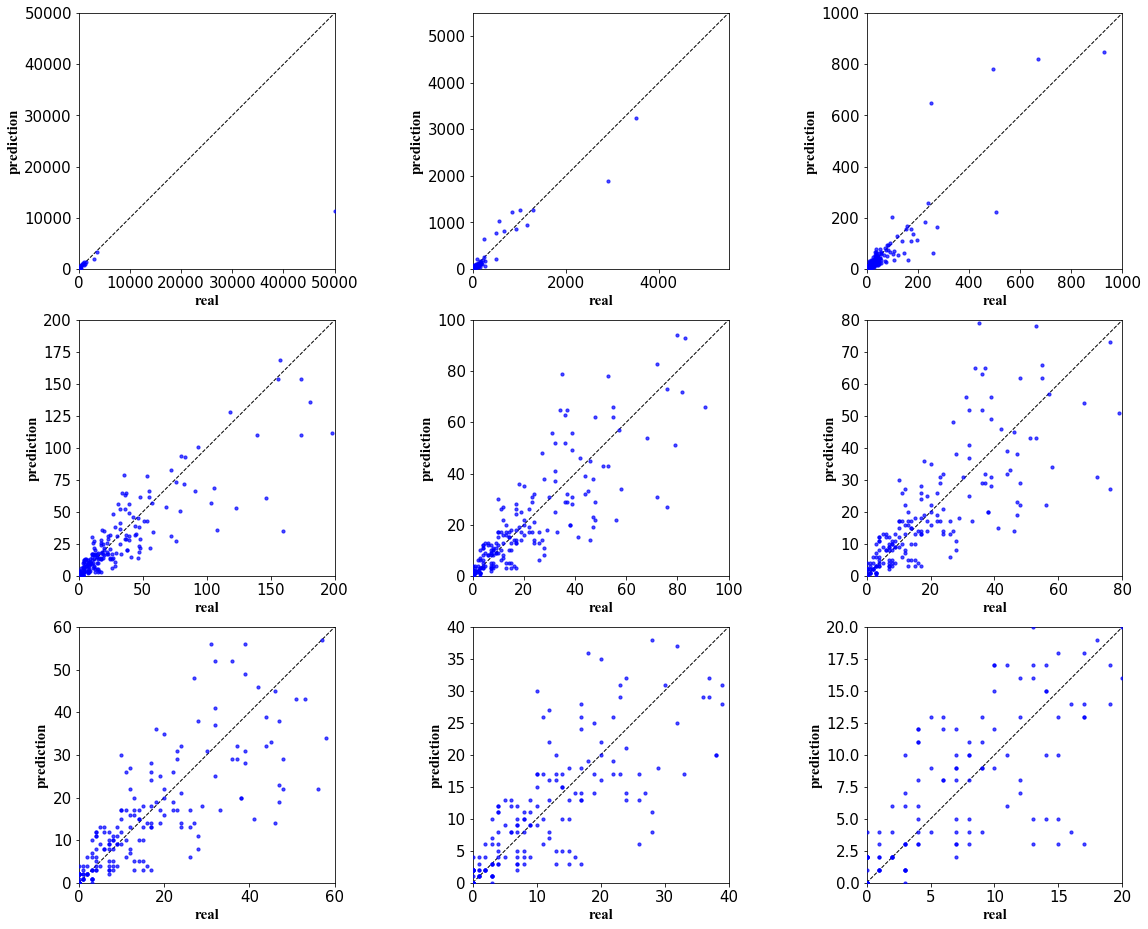

#########################################
test fold 3
预测误差较大城市，绝对值误差阈值设置为50
北京市   real: 580   pre:175.0
上海市   real: 516   pre:135.0
宁波市   real: 157   pre:65.0
阜阳市   real: 155   pre:101.0
新余市   real: 130   pre:12.0
宜昌市   real: 931   pre:752.0
鄂州市   real: 1394   pre:3694.0
荆州市   real: 1580   pre:1522.0
潜江市   real: 198   pre:466.0
邵阳市   real: 102   pre:31.0
广州市   real: 435   pre:195.0
深圳市   real: 450   pre:195.0
佛山市   real: 93   pre:168.0
重庆市   real: 579   pre:211.0
甘孜藏族自治州   real: 78   pre:6.0
西安市   real: 120   pre:212.0
R-squared 0.6716218856183197
R 0.819525402668105
mae 50.141666666666666
rmse 224.2553418167187


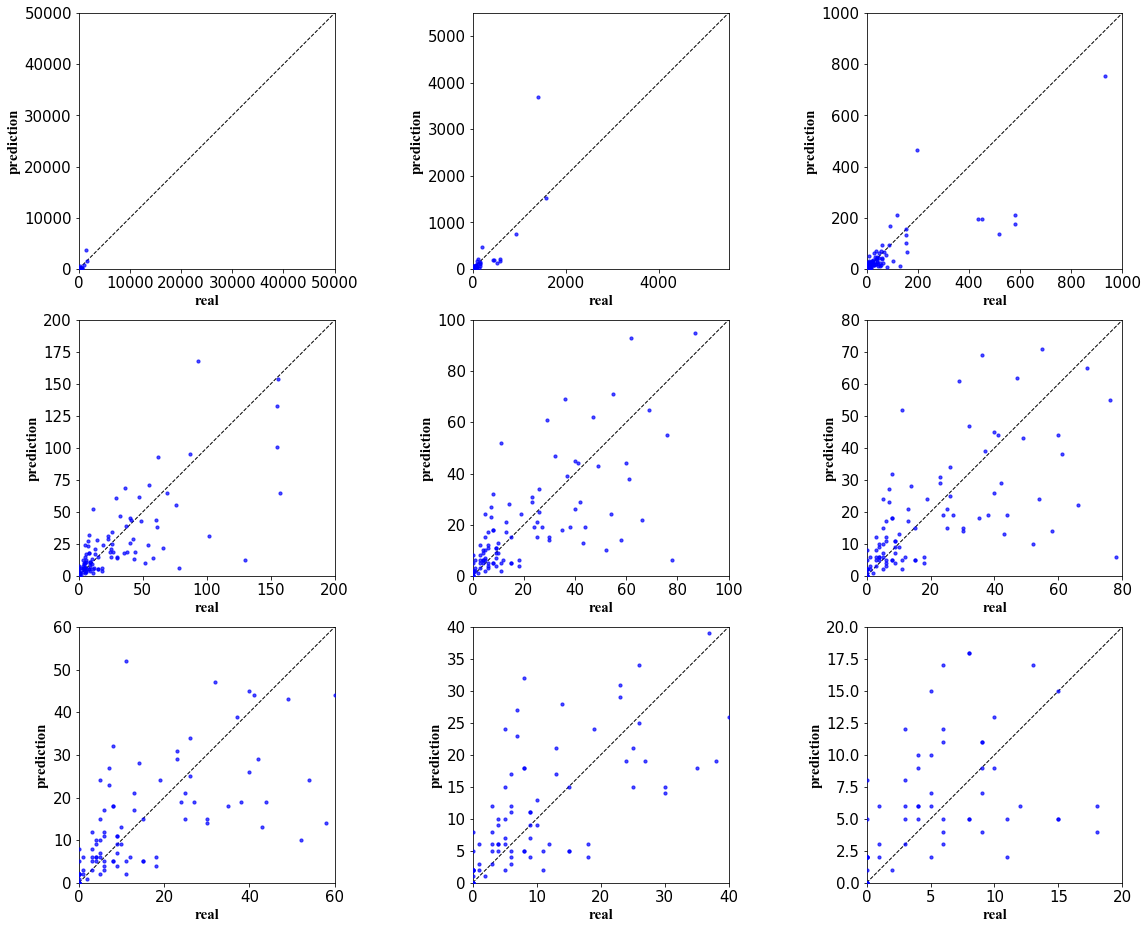

************* cv evaluation ***************
R-squared 0.05334894284415661
R 0.2309739007856875
mae 185.45152354570638
rmse 2596.900322561218


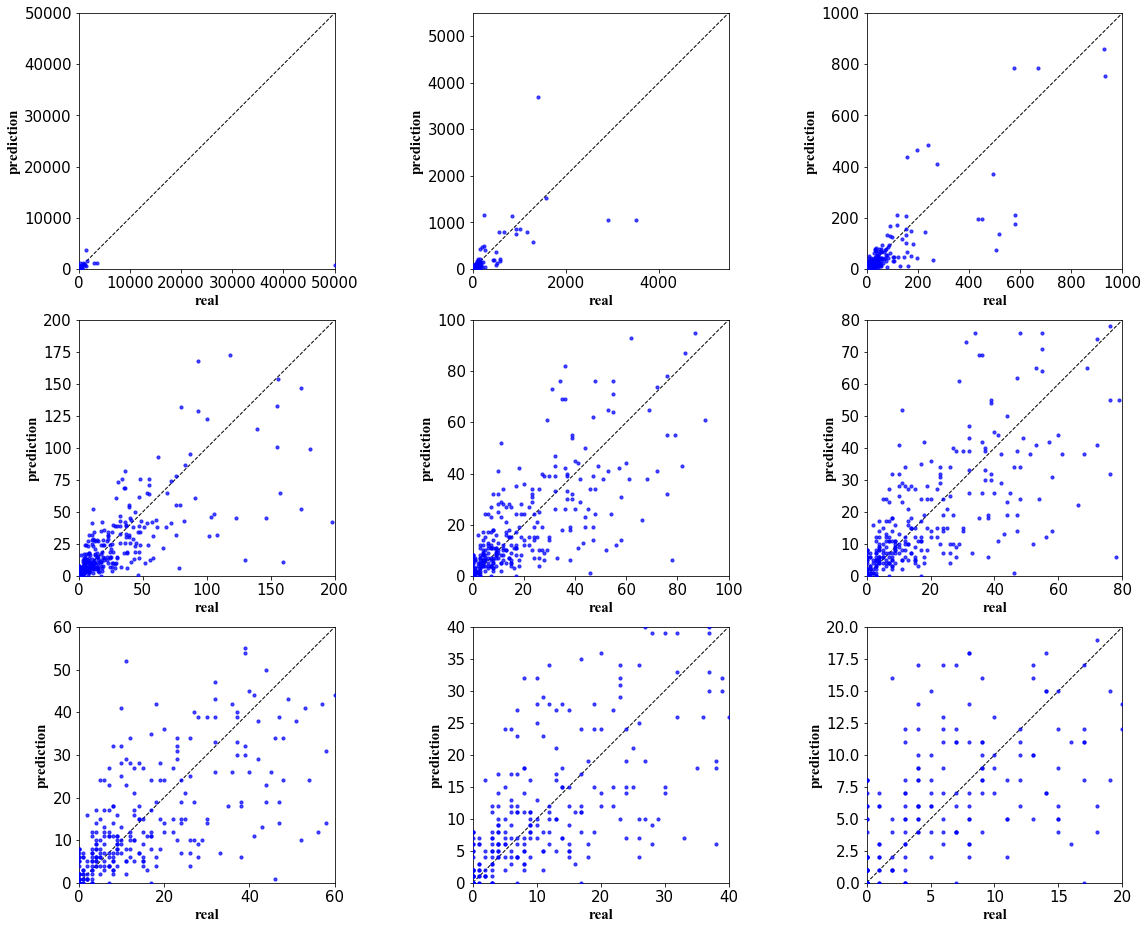

%%%%%% feature importances %%%%%%


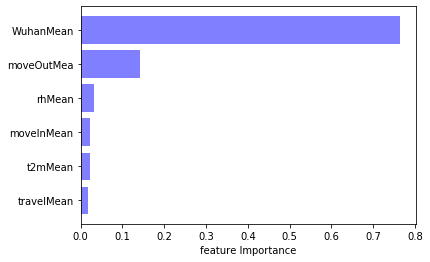

In [124]:
df = gp.GeoDataFrame.from_file("../shp/china_city_distinct_COVID19.shp")
    
kf = KFold(3, True)
index = []
for train_index, test_index in kf.split(df):
    index.append((train_index, test_index))

# epidemic id 疫情灾区id，暂定武汉
epidemicIds = [420100]

# 全时间段建模
#df = df[~df['id'].isin(epidemicIds)]
case, df_predict = covid_all_predict(df, index, threshold = 50)

In [125]:
df = pd.merge(df, df_predict, how='inner', on='id')
df['diff'] = df['confirmed'] - df['predict']
df = df[df['id'].isin(case)]
df = df[['id','location','confirmed', 'predict',
    'rhMean',
    't2mMean',
    'moveInMean',
    'moveOutMea',
    'travelMean',
    'WuhanMean',
     'diff']]

In [126]:
# 预测过低的城市

# 湖北城市很多预测过低，比如随州，荆州，襄阳，黄石，宜昌，这些城市的WuhanMean和confirmed并不完全呈正向关系，气候特征和其他交通基本相近

# 温州预测很低，这个城市流动人口很多，是浙江疫情最严重的城市，但是百度迁徙平台上相关的指数很低，尤其是WuhanMean，应该是数据存在些误差，迁入迁出温州的人大部分是务工人员，可能不用百度？？？

# 甘孜藏族自治州，双鸭山市，新余市，蚌埠市，济宁市，哈尔滨市，这些城市确诊人数在50~300，但是预测值均在30以下，其共同特点是WuhanMean很低，几乎接近于0

# 其他预测过低的城市共同的特征都是WuhanMean分布较为接近


# 虽然WuhanMean特征能够表征携带病毒人群的迁徙导致疫情扩散，但是很多城市并不是与武汉有直接的联系，
# 或许需要加入城市与省会城市的迁徙关系，算是人口的二次迁徙，而普通机器学习筛选再多的特征，对于这种空间图的表征都要弱很多，或许需要图卷积试一下效果

In [127]:
df[df['diff']>0].sort_values(by='diff', ascending=False)

,id,location,confirmed,predict,rhMean,t2mMean,moveInMean,moveOutMea,travelMean,WuhanMean,diff
167,420100,武汉市,50006,845.0,71.607512,282.498292,1.441894,2.023355,1.722975,100.000000,49161.0
174,420900,孝感市,3518,1055.0,71.152424,281.712290,0.581259,0.472132,2.987432,15.480989,2463.0
176,421100,黄冈市,2907,1055.0,73.669439,281.858747,0.785669,0.582993,3.386525,18.594066,1852.0
178,421300,随州市,1307,588.0,70.903198,281.069625,0.238099,0.192810,2.924918,2.167692,719.0
88,330300,温州市,504,73.0,78.798802,284.332806,1.139140,1.407472,3.042697,0.088022,431.0
0,110000,北京市,580,175.0,46.602664,272.940185,4.460553,4.917454,3.281025,0.467143,405.0
171,420600,襄阳市,1175,787.0,71.201756,280.692857,0.499872,0.428895,3.136352,3.597582,388.0
72,310000,上海市,516,135.0,73.452783,282.566128,4.328343,4.793034,3.975281,0.468352,381.0
251,500000,重庆市,579,211.0,77.692175,282.481705,3.243957,3.053466,3.642029,0.571319,368.0
200,440300,深圳市,450,195.0,75.376723,291.932983,5.067225,5.783426,2.831347,0.468242,255.0


In [128]:
# 预测过高的城市

# 湖北城市很多预测过高，比如仙桃市，恩施土家族苗族自治州，十堰市，潜江市，神农架林区，鄂州市，这些城市的WuhanMean较高，
# 尤其是恩施，WuhanMean很高，我查了一下，1月份武汉迁入恩施的比例排在top10，2月份排在top5，会是很多志愿者或者医务人员的迁徙？？？
# 恩施确诊人数是湖北第3少的城市，另两个是潜江和神农架，这两个人数也很少，一个97万，一个8万，而恩施是402万，说明恩施的管控严格？？？

# 与上面预测过低的城市对比来看，有个非常明显的问题：这些过高或过低城市的WuhanMean与confirmed并不完全呈现正向关系，
# 有些城市WuhanMean差不多，但是confirmed差异较大，而其他特征又很相近，所以模型也难以做出判断，考虑需要进一步挖掘特征，能够充分区分城市

In [129]:
df[df['diff']<0].sort_values(by='diff', ascending=True)

,id,location,confirmed,predict,rhMean,t2mMean,moveInMean,moveOutMea,travelMean,WuhanMean,diff
172,420700,鄂州市,1394,3694.0,73.026692,283.062423,0.230197,0.226363,2.240659,4.990220,-2300.0
179,422800,恩施土家族苗族自治州,252,1152.0,81.020041,279.809750,0.415623,0.325181,3.908862,4.745824,-900.0
177,421200,咸宁市,836,1126.0,76.139420,282.601893,0.329820,0.267432,3.433240,6.370220,-290.0
149,410100,郑州市,157,437.0,58.902450,280.062032,3.181735,3.165202,3.335111,0.483516,-280.0
181,429005,潜江市,198,466.0,71.633491,282.448468,0.142624,0.125334,2.839349,1.044615,-268.0
184,430100,长沙市,242,483.0,78.196887,283.294240,3.008522,3.068457,3.394593,0.728791,-241.0
180,429004,仙桃市,575,784.0,71.841891,282.427655,0.207499,0.168606,2.855342,2.961538,-209.0
163,411500,信阳市,274,411.0,69.734162,281.110669,0.861081,0.741462,3.872826,0.590879,-137.0
169,420300,十堰市,672,784.0,71.845056,279.256399,0.275357,0.244492,3.025281,3.124835,-112.0
305,610100,西安市,120,212.0,63.974433,278.483058,3.199712,3.349754,3.132052,0.203077,-92.0


In [ ]:
# 管控前各个城市疫情预测

train fold 1
预测误差较大城市，绝对值误差阈值设置为20
武汉市   real: 698   pre:246.0
荆门市   real: 90   pre:52.0
重庆市   real: 110   pre:67.0
R-squared 0.8465157088597797
R 0.9200628831008126
mae 3.8375
rmse 29.571453013562476


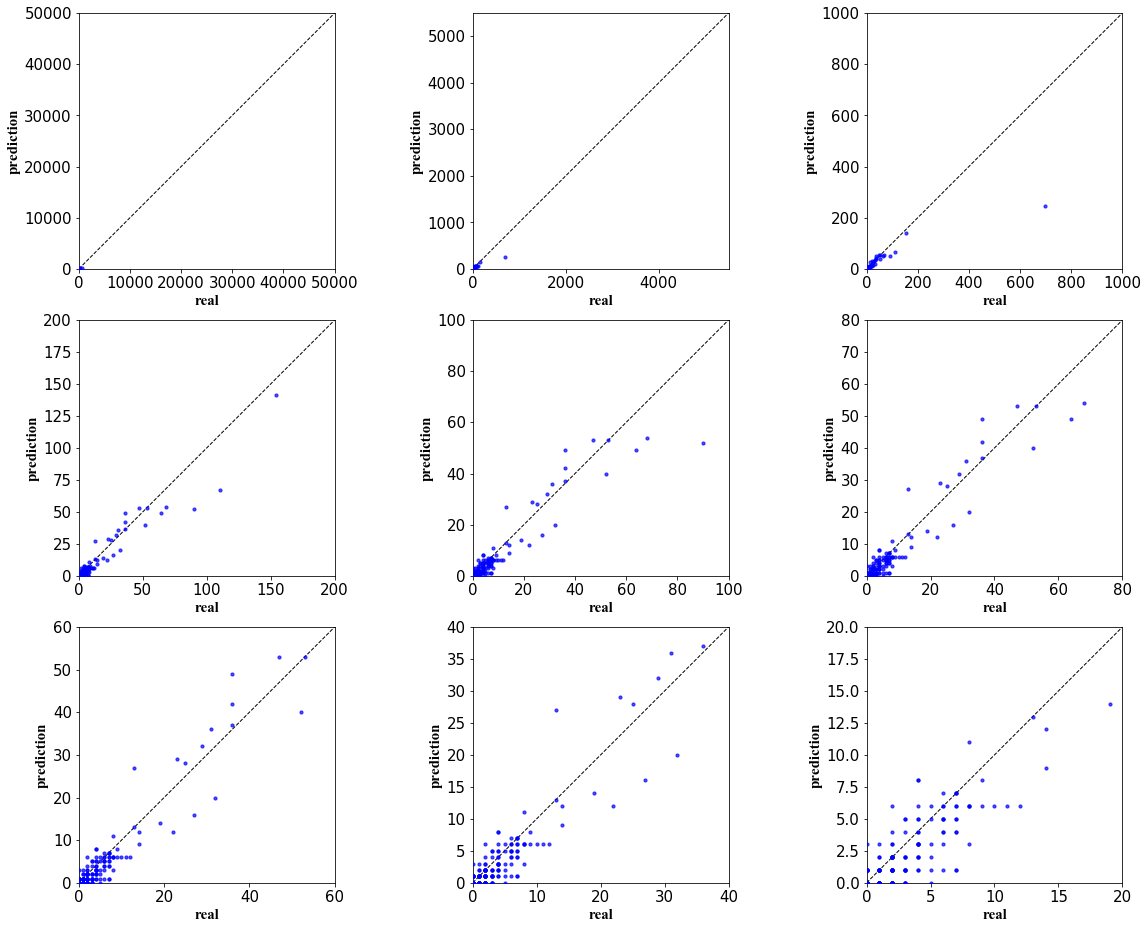

#########################################
test fold 1
预测误差较大城市，绝对值误差阈值设置为20
鄂州市   real: 20   pre:47.0
孝感市   real: 100   pre:141.0
仙桃市   real: 12   pre:41.0
潜江市   real: 5   pre:30.0
长沙市   real: 22   pre:43.0
广州市   real: 39   pre:67.0
R-squared 0.8483406855953723
R 0.9210541165400502
mae 3.1818181818181817
rmse 7.188719353988805


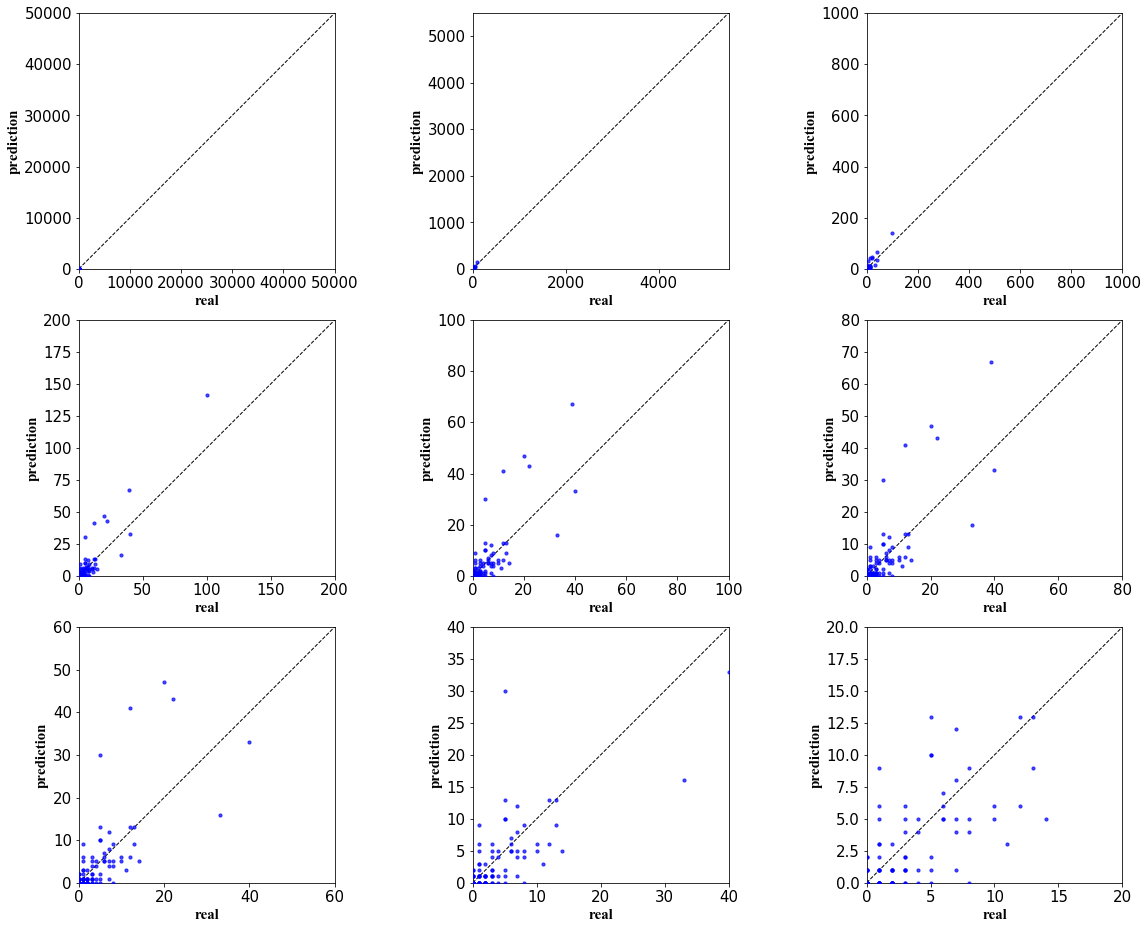

train fold 2
预测误差较大城市，绝对值误差阈值设置为20
荆门市   real: 90   pre:54.0
孝感市   real: 100   pre:55.0
咸宁市   real: 64   pre:39.0
R-squared 0.9220475305201666
R 0.9602330605223748
mae 1.8630705394190872
rmse 4.742760370671278


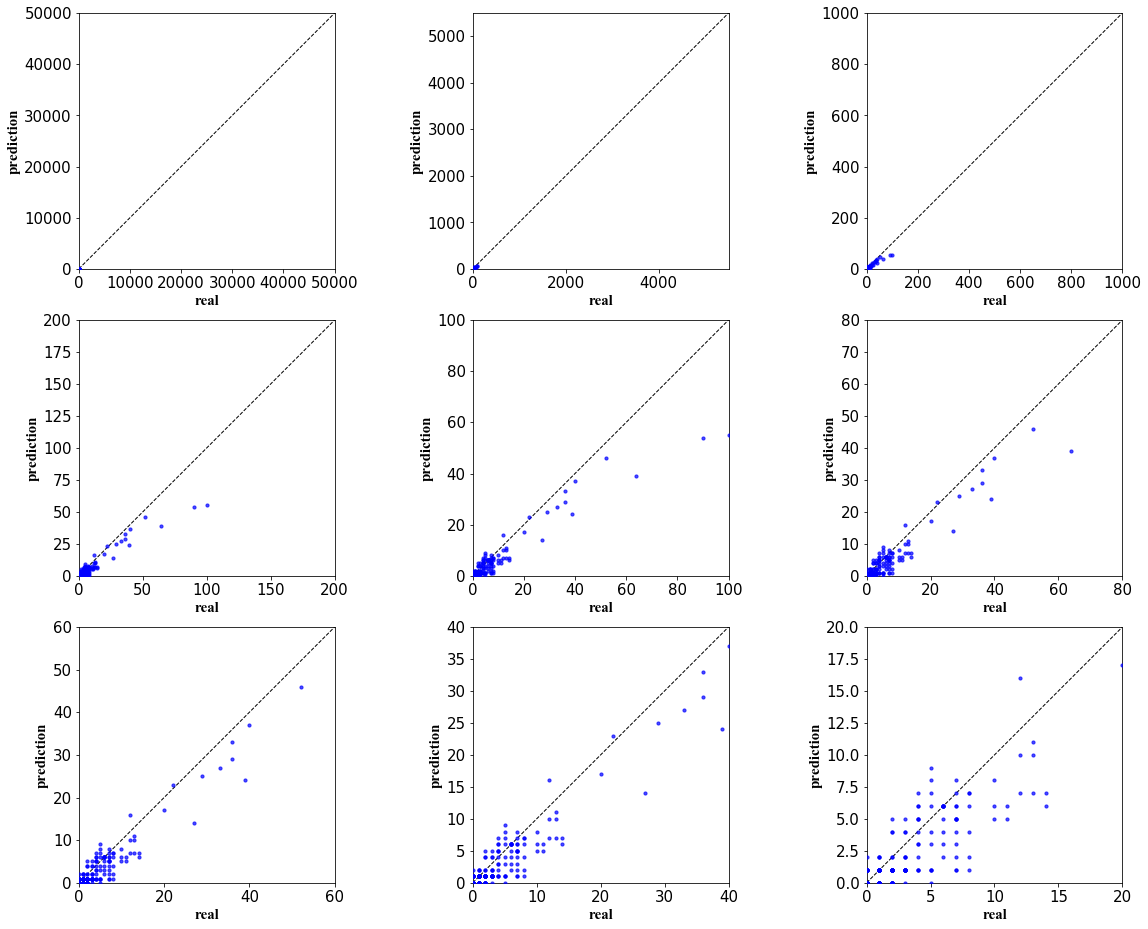

#########################################
test fold 2
预测误差较大城市，绝对值误差阈值设置为20
北京市   real: 68   pre:25.0
上海市   real: 53   pre:24.0
温州市   real: 32   pre:7.0
武汉市   real: 698   pre:46.0
黄冈市   real: 154   pre:46.0
重庆市   real: 110   pre:23.0
R-squared 0.3926088626388108
R 0.6265850801278393
mae 9.55
rmse 61.156356987642745


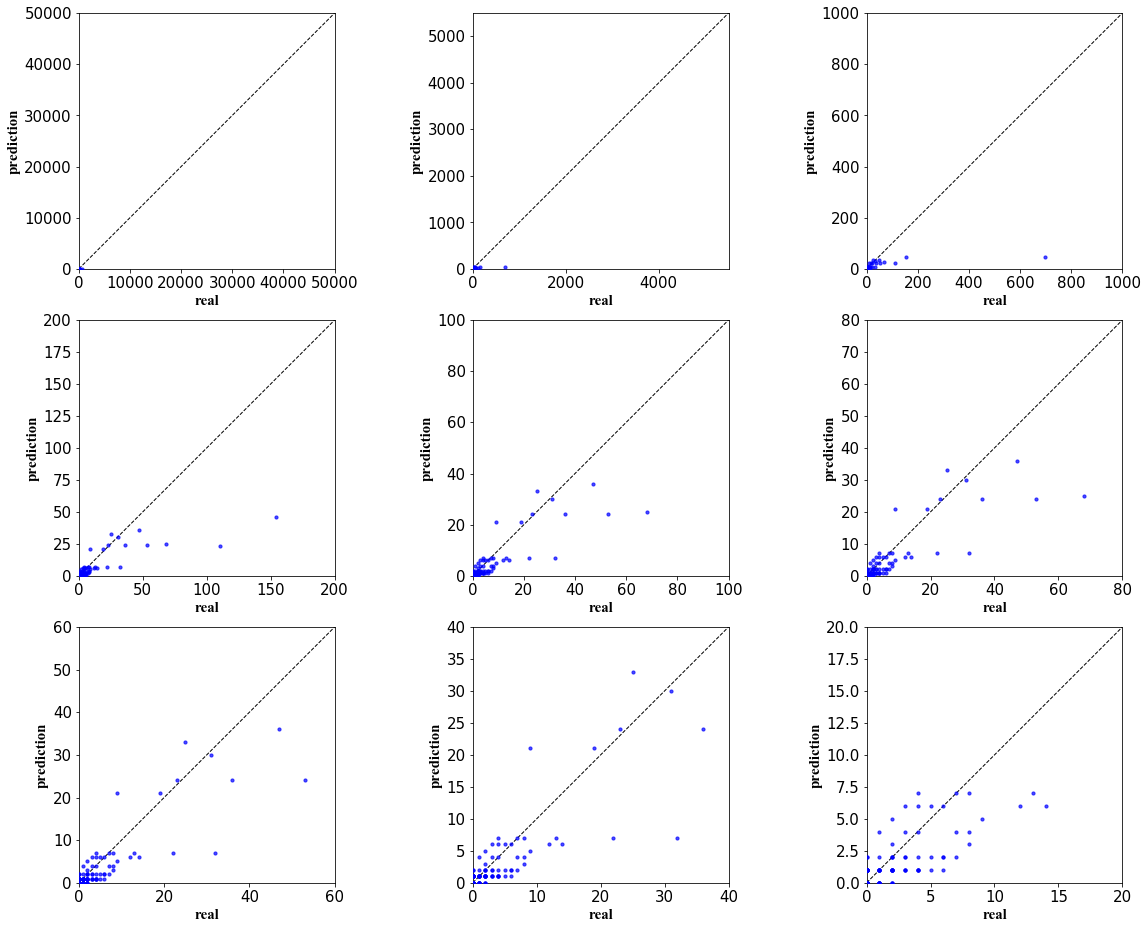

train fold 3
预测误差较大城市，绝对值误差阈值设置为20
武汉市   real: 698   pre:166.0
孝感市   real: 100   pre:75.0
黄冈市   real: 154   pre:75.0
重庆市   real: 110   pre:53.0
R-squared 0.7747289167841744
R 0.8801868646964544
mae 4.352697095435684
rmse 34.99193742345946


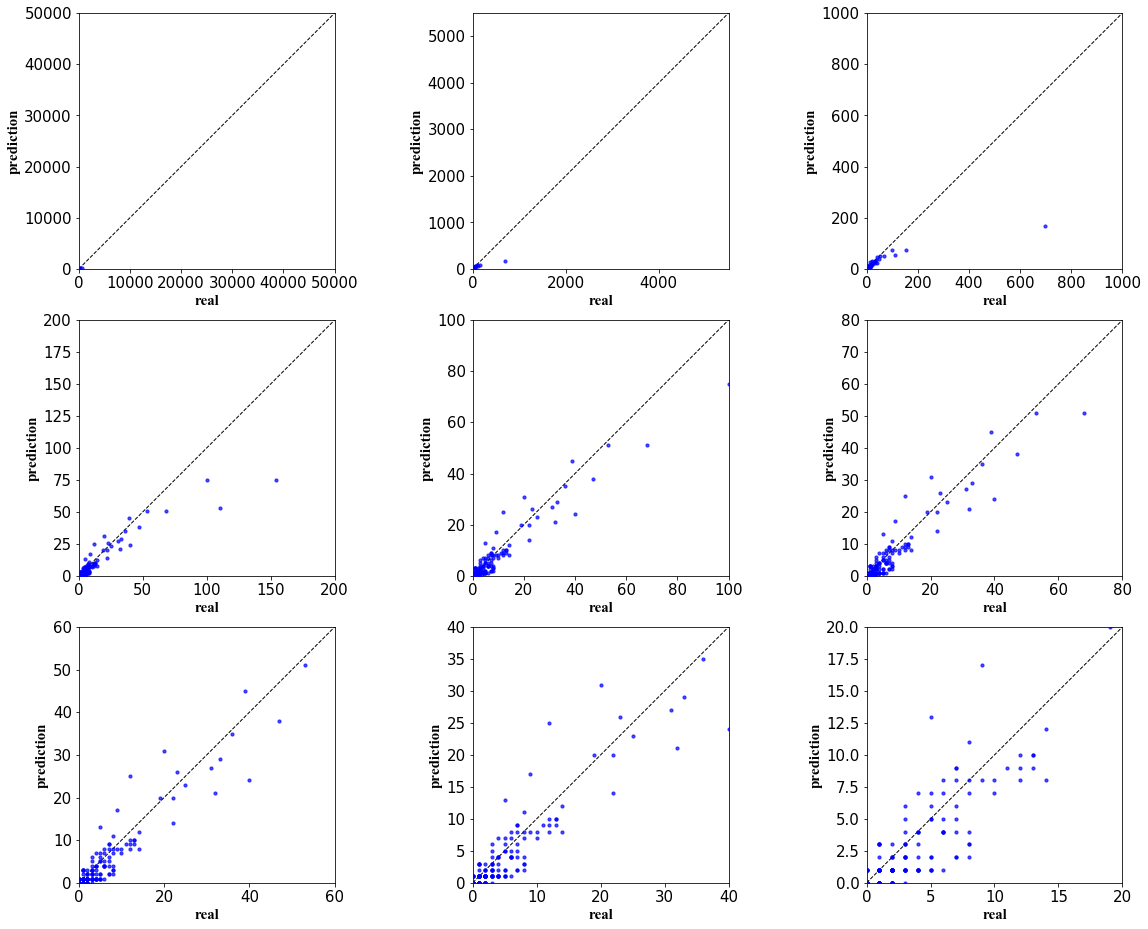

#########################################
test fold 3
预测误差较大城市，绝对值误差阈值设置为20
荆门市   real: 90   pre:26.0
咸宁市   real: 64   pre:25.0
随州市   real: 52   pre:19.0
R-squared 0.6670954902915373
R 0.8167591384805788
mae 3.0166666666666666
rmse 8.10246875958186


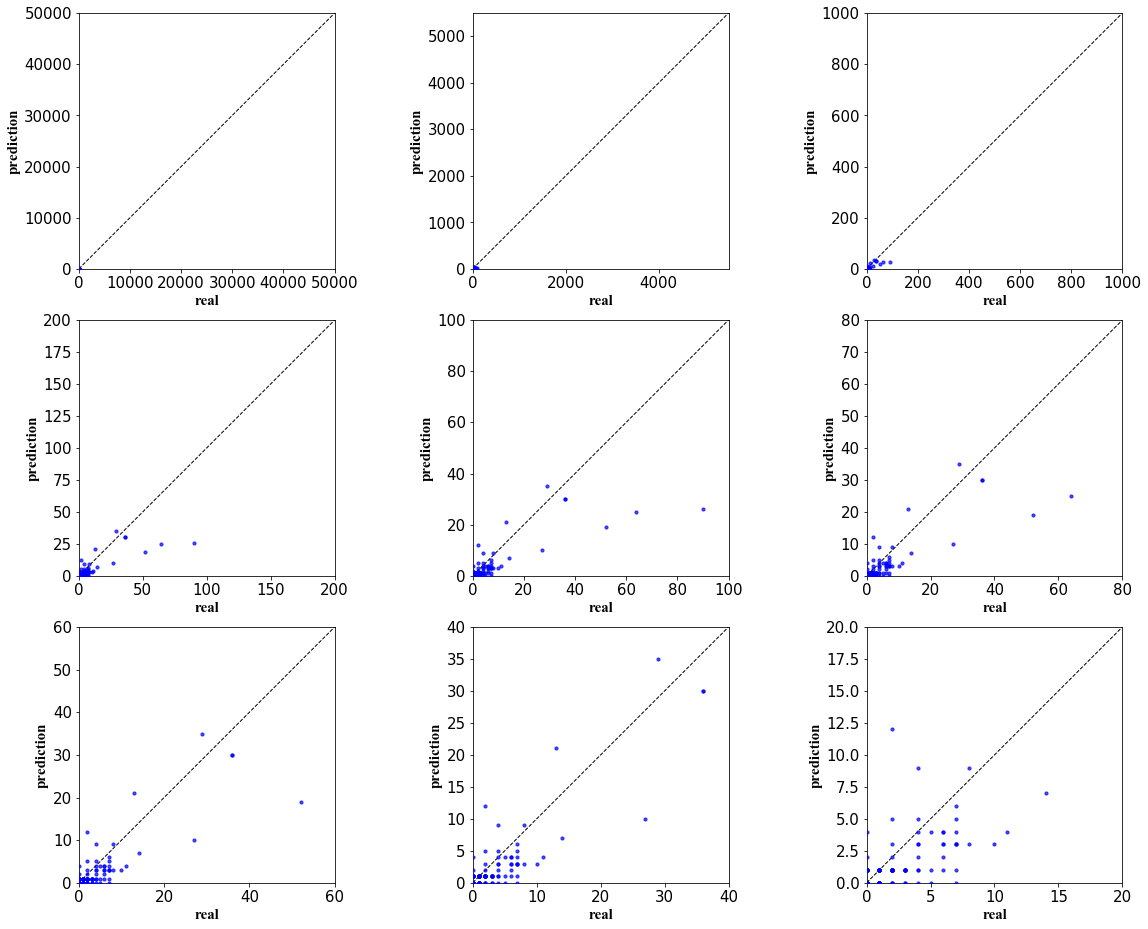

************* cv evaluation ***************
R-squared 0.2023580074399067
R 0.44984220282217485
mae 5.243767313019391
rmse 35.81048145051183


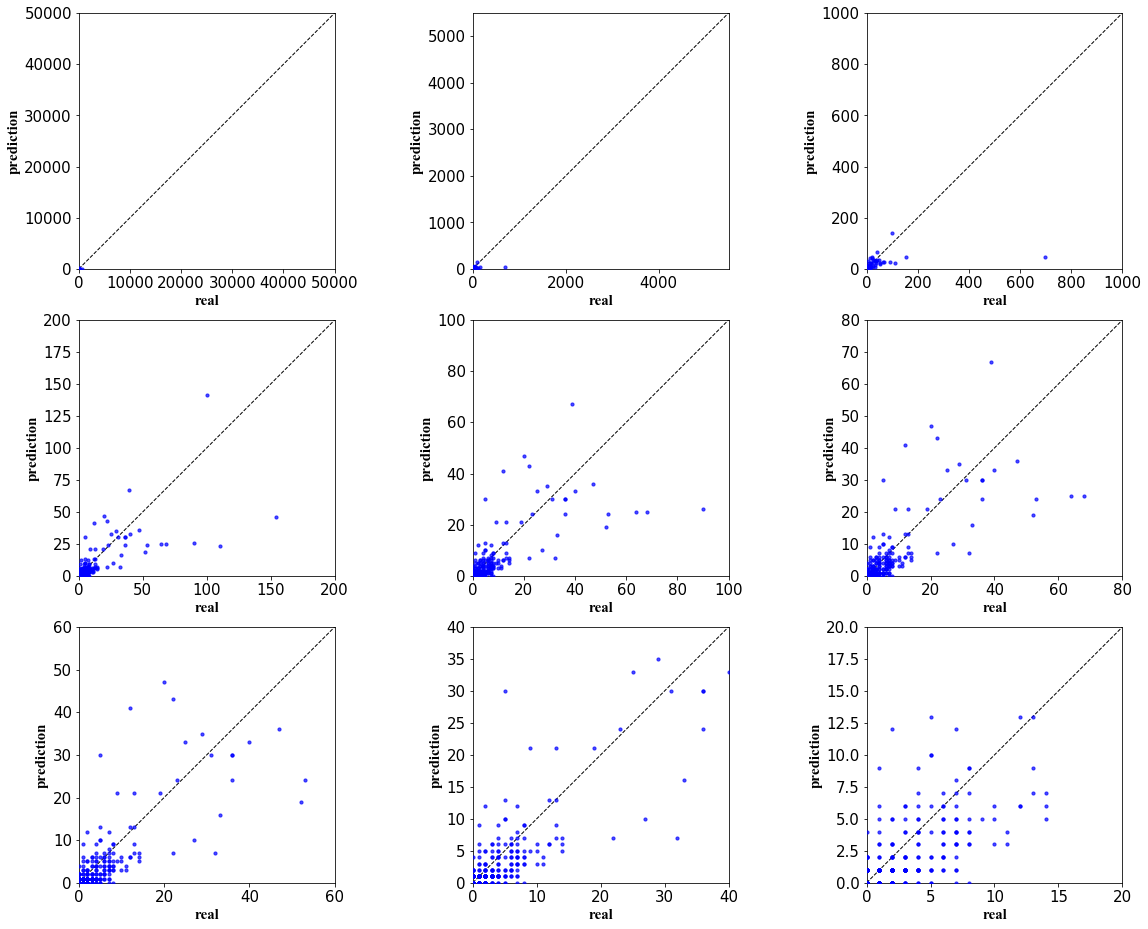

%%%%%% feature importances %%%%%%


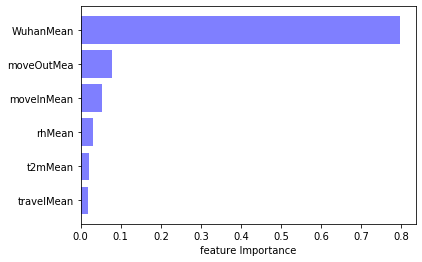

In [130]:
df = gp.GeoDataFrame.from_file("../shp/china_city_distinct_COVID19_before.shp")  
kf = KFold(3, True)
index = []
for train_index, test_index in kf.split(df):
    index.append((train_index, test_index))

# epidemic id 疫情灾区id，暂定武汉
epidemicIds = [420100]

# 全时间段建模
#df = df[~df['id'].isin(epidemicIds)]
case, df_predict = covid_all_predict(df, index, threshold = 20)

In [131]:
df = pd.merge(df, df_predict, how='inner', on='id')
df['diff'] = df['confirmed'] - df['predict']
df = df[df['id'].isin(case)]
df = df[['id','location','confirmed', 'predict',
    'rhMean',
    't2mMean',
    'moveInMean',
    'moveOutMea',
    'travelMean',
    'WuhanMean',
     'diff']]

In [132]:
df[df['diff']>0].sort_values(by='diff', ascending=False)

,id,location,confirmed,predict,rhMean,t2mMean,moveInMean,moveOutMea,travelMean,WuhanMean,diff
167,420100,武汉市,698,46.0,82.161216,277.927893,3.691429,6.322494,4.120335,100.000000,652.0
176,421100,黄冈市,154,46.0,82.857096,277.756878,2.274531,1.006516,4.852458,12.606538,108.0
251,500000,重庆市,110,23.0,81.690700,279.615017,6.699337,5.046055,5.064838,1.210385,87.0
173,420800,荆门市,90,26.0,79.101923,277.325860,0.786025,0.501414,5.055546,3.047308,64.0
0,110000,北京市,68,25.0,46.952353,267.598395,8.432141,13.719755,5.149477,1.179615,43.0
177,421200,咸宁市,64,25.0,86.336734,278.122550,0.928249,0.532652,5.350531,5.103462,39.0
178,421300,随州市,52,19.0,79.398717,276.382933,0.649905,0.343983,4.675454,2.953077,33.0
72,310000,上海市,53,24.0,80.613952,280.957940,6.154784,12.054880,5.327500,0.891154,29.0
88,330300,温州市,32,7.0,81.075343,283.464677,1.632216,3.456391,4.197485,0.201538,25.0


In [133]:
df[df['diff']<0].sort_values(by='diff', ascending=True)

,id,location,confirmed,predict,rhMean,t2mMean,moveInMean,moveOutMea,travelMean,WuhanMean,diff
174,420900,孝感市,100,141.0,80.659195,277.136510,1.596307,0.961099,4.722062,13.395769,-41.0
180,429004,仙桃市,12,41.0,81.704573,277.975140,0.526281,0.306374,4.384712,2.761154,-29.0
198,440100,广州市,39,67.0,71.248583,290.618403,7.572659,14.140525,3.804012,0.671154,-28.0
172,420700,鄂州市,20,47.0,83.553880,278.572922,0.605509,0.549913,4.082238,4.457692,-27.0
181,429005,潜江市,5,30.0,79.753080,277.999688,0.332992,0.221503,4.443785,1.108462,-25.0
184,430100,长沙市,22,43.0,85.910260,279.149545,4.208644,6.180231,4.447612,1.194231,-21.0


In [ ]:
# 管控前预测过高和过低的情况与全时间段基本类似

train fold 1
预测误差较大城市，绝对值误差阈值设置为50
上海市   real: 463   pre:321.0
杭州市   real: 154   pre:94.0
温州市   real: 472   pre:86.0
台州市   real: 124   pre:28.0
蚌埠市   real: 157   pre:10.0
亳州市   real: 102   pre:25.0
南昌市   real: 222   pre:151.0
新余市   real: 127   pre:7.0
宜春市   real: 100   pre:32.0
上饶市   real: 117   pre:59.0
信阳市   real: 251   pre:177.0
驻马店市   real: 130   pre:74.0
武汉市   real: 49308   pre:10375.0
十堰市   real: 632   pre:891.0
宜昌市   real: 900   pre:1010.0
鄂州市   real: 1374   pre:1003.0
孝感市   real: 3418   pre:2044.0
荆州市   real: 1533   pre:921.0
随州市   real: 1255   pre:1078.0
潜江市   real: 193   pre:274.0
天门市   real: 483   pre:738.0
娄底市   real: 69   pre:14.0
珠海市   real: 91   pre:28.0
甘孜藏族自治州   real: 76   pre:21.0
R-squared 0.9405471440770609
R 0.9698180984478795
mae 189.55
rmse 2515.5002236135856


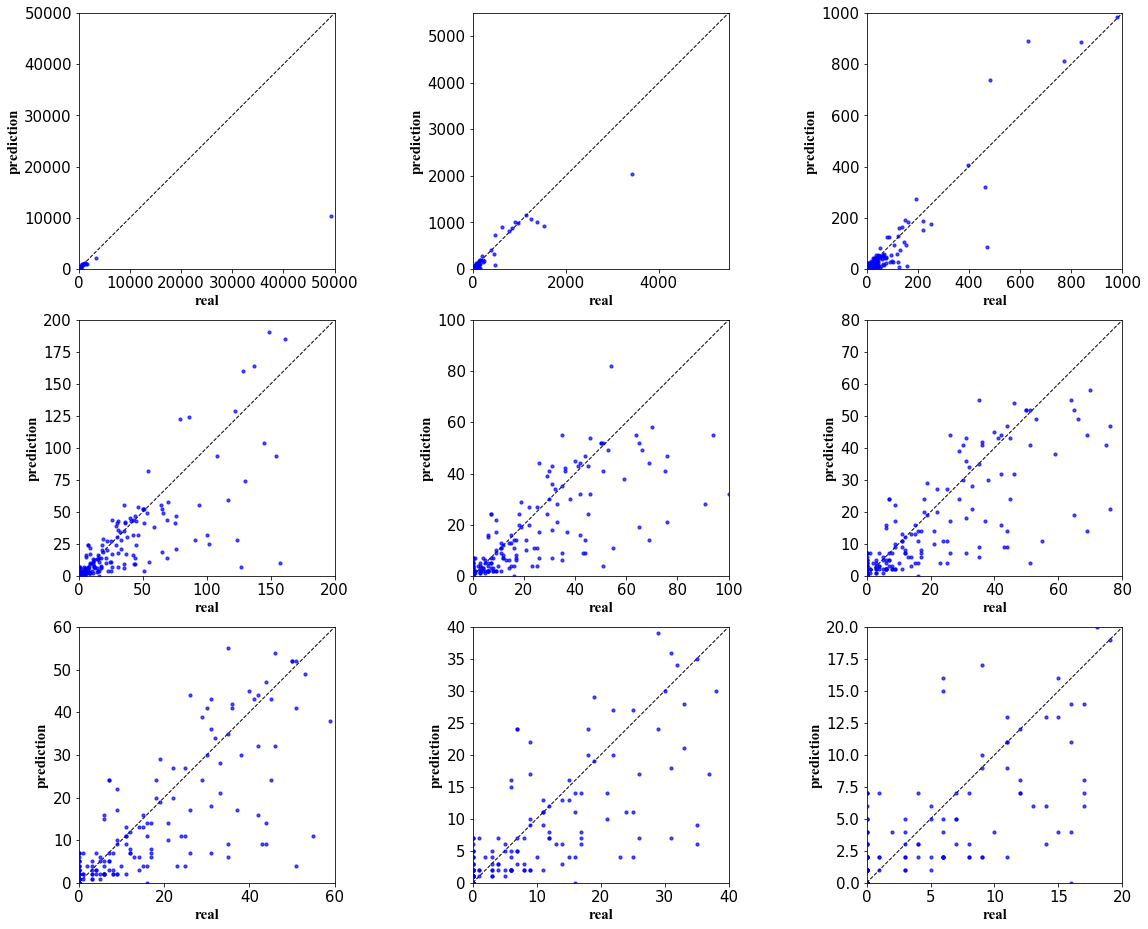

#########################################
test fold 1
预测误差较大城市，绝对值误差阈值设置为50
北京市   real: 512   pre:89.0
天津市   real: 160   pre:66.0
哈尔滨市   real: 190   pre:31.0
宁波市   real: 144   pre:52.0
九江市   real: 114   pre:191.0
济宁市   real: 255   pre:41.0
黄冈市   real: 2753   pre:1391.0
恩施土家族苗族自治州   real: 227   pre:825.0
仙桃市   real: 563   pre:969.0
株洲市   real: 75   pre:210.0
东莞市   real: 98   pre:215.0
重庆市   real: 469   pre:221.0
R-squared 0.7055931175269421
R 0.8399959032798565
mae 39.80165289256198
rmse 151.08122712661108


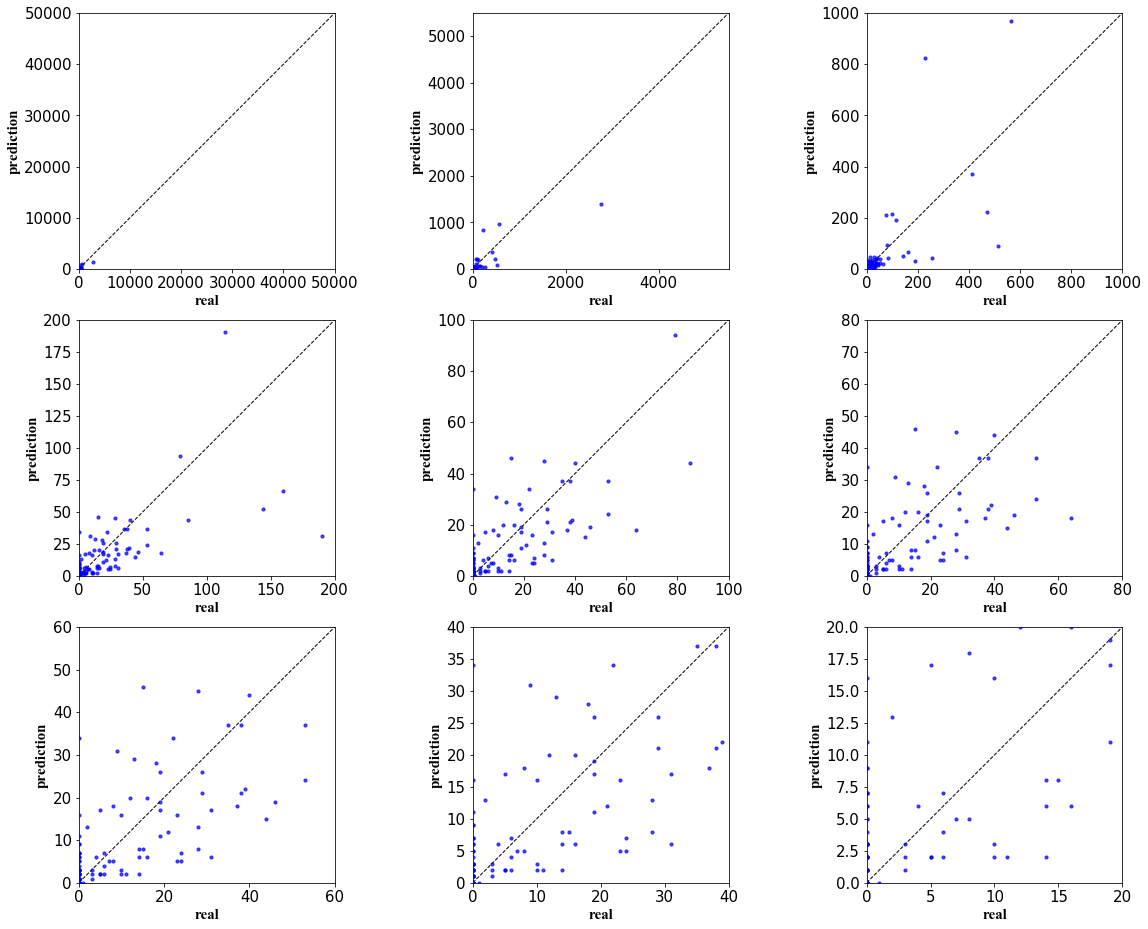

train fold 2
预测误差较大城市，绝对值误差阈值设置为50
北京市   real: 512   pre:180.0
天津市   real: 160   pre:90.0
哈尔滨市   real: 190   pre:62.0
宁波市   real: 144   pre:53.0
新余市   real: 127   pre:6.0
宜春市   real: 100   pre:37.0
济宁市   real: 255   pre:41.0
郑州市   real: 128   pre:219.0
驻马店市   real: 130   pre:59.0
十堰市   real: 632   pre:715.0
宜昌市   real: 900   pre:990.0
襄阳市   real: 1139   pre:711.0
鄂州市   real: 1374   pre:1070.0
黄冈市   real: 2753   pre:981.0
咸宁市   real: 772   pre:947.0
随州市   real: 1255   pre:992.0
仙桃市   real: 563   pre:885.0
株洲市   real: 75   pre:182.0
广州市   real: 396   pre:341.0
重庆市   real: 469   pre:244.0
甘孜藏族自治州   real: 76   pre:17.0
R-squared 0.7729634288372046
R 0.879183387489325
mae 27.448132780082986
rmse 128.03200779784282


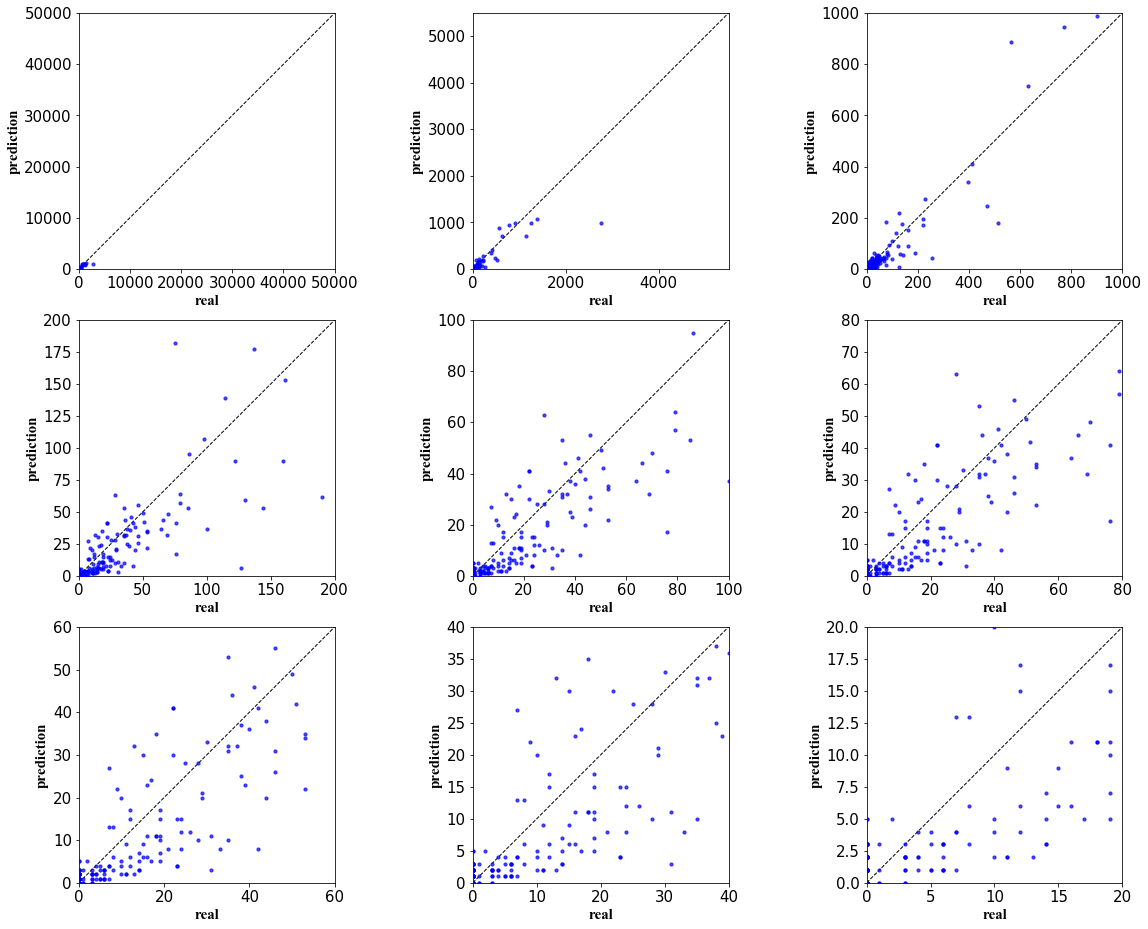

#########################################
test fold 2
预测误差较大城市，绝对值误差阈值设置为50
双鸭山市   real: 51   pre:0.0
上海市   real: 463   pre:154.0
杭州市   real: 154   pre:64.0
温州市   real: 472   pre:30.0
台州市   real: 124   pre:11.0
蚌埠市   real: 157   pre:5.0
阜阳市   real: 145   pre:64.0
亳州市   real: 102   pre:9.0
莆田市   real: 55   pre:3.0
抚州市   real: 65   pre:10.0
上饶市   real: 117   pre:31.0
信阳市   real: 251   pre:153.0
武汉市   real: 49308   pre:597.0
黄石市   real: 979   pre:898.0
孝感市   real: 3418   pre:880.0
荆州市   real: 1533   pre:803.0
潜江市   real: 193   pre:728.0
天门市   real: 483   pre:905.0
邵阳市   real: 94   pre:18.0
娄底市   real: 69   pre:16.0
珠海市   real: 91   pre:11.0
R-squared 0.10048101645577613
R 0.3169874074088372
mae 465.325
rmse 4454.042960240356


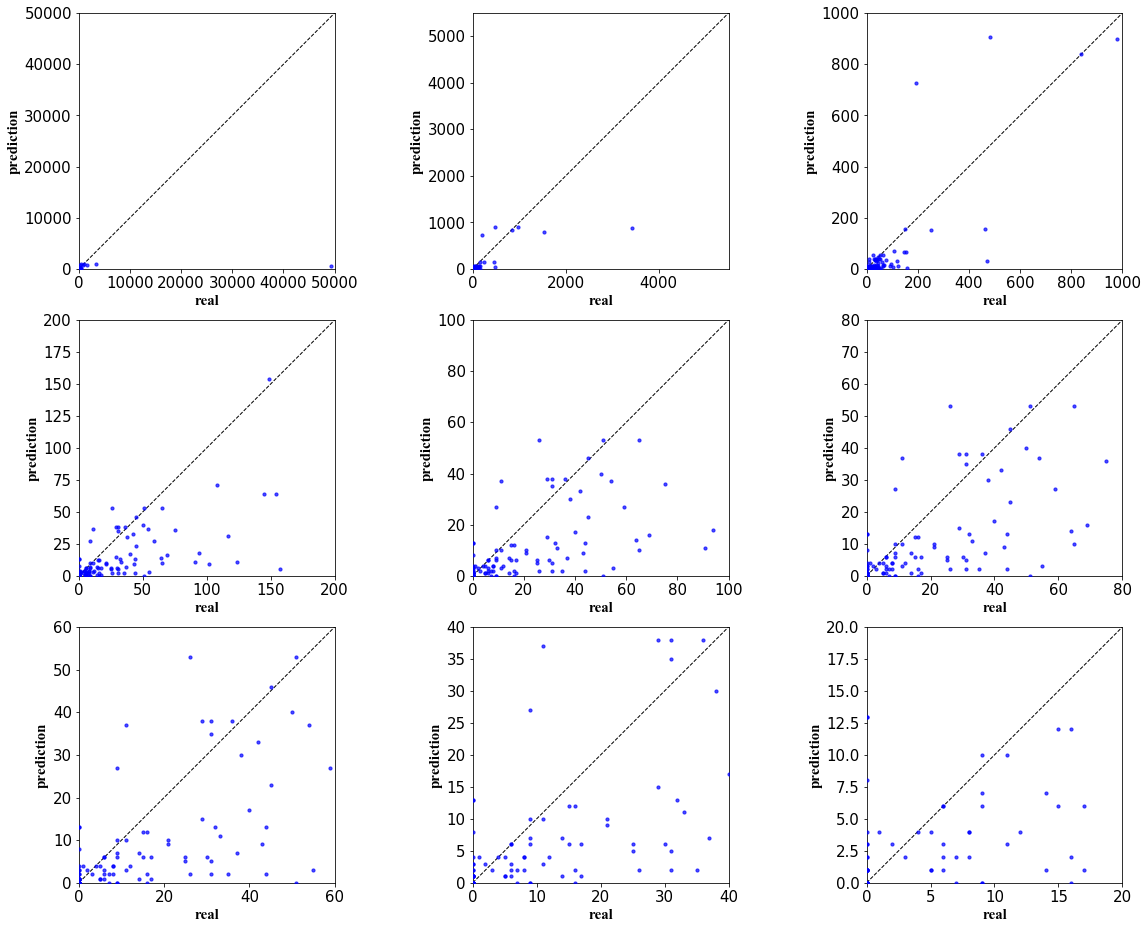

train fold 3
预测误差较大城市，绝对值误差阈值设置为50
北京市   real: 512   pre:234.0
哈尔滨市   real: 190   pre:76.0
上海市   real: 463   pre:225.0
杭州市   real: 154   pre:82.0
宁波市   real: 144   pre:67.0
温州市   real: 472   pre:75.0
台州市   real: 124   pre:60.0
蚌埠市   real: 157   pre:46.0
阜阳市   real: 145   pre:60.0
亳州市   real: 102   pre:21.0
九江市   real: 114   pre:176.0
上饶市   real: 117   pre:38.0
济宁市   real: 255   pre:42.0
武汉市   real: 49308   pre:20635.0
黄石市   real: 979   pre:725.0
荆门市   real: 838   pre:603.0
孝感市   real: 3418   pre:2021.0
荆州市   real: 1533   pre:897.0
黄冈市   real: 2753   pre:2021.0
恩施土家族苗族自治州   real: 227   pre:638.0
潜江市   real: 193   pre:256.0
邵阳市   real: 94   pre:13.0
岳阳市   real: 149   pre:277.0
娄底市   real: 69   pre:14.0
珠海市   real: 91   pre:20.0
东莞市   real: 98   pre:149.0
重庆市   real: 469   pre:361.0
R-squared 0.9955168013821116
R 0.9977558826597374
mae 150.8298755186722
rmse 1851.1036586822258


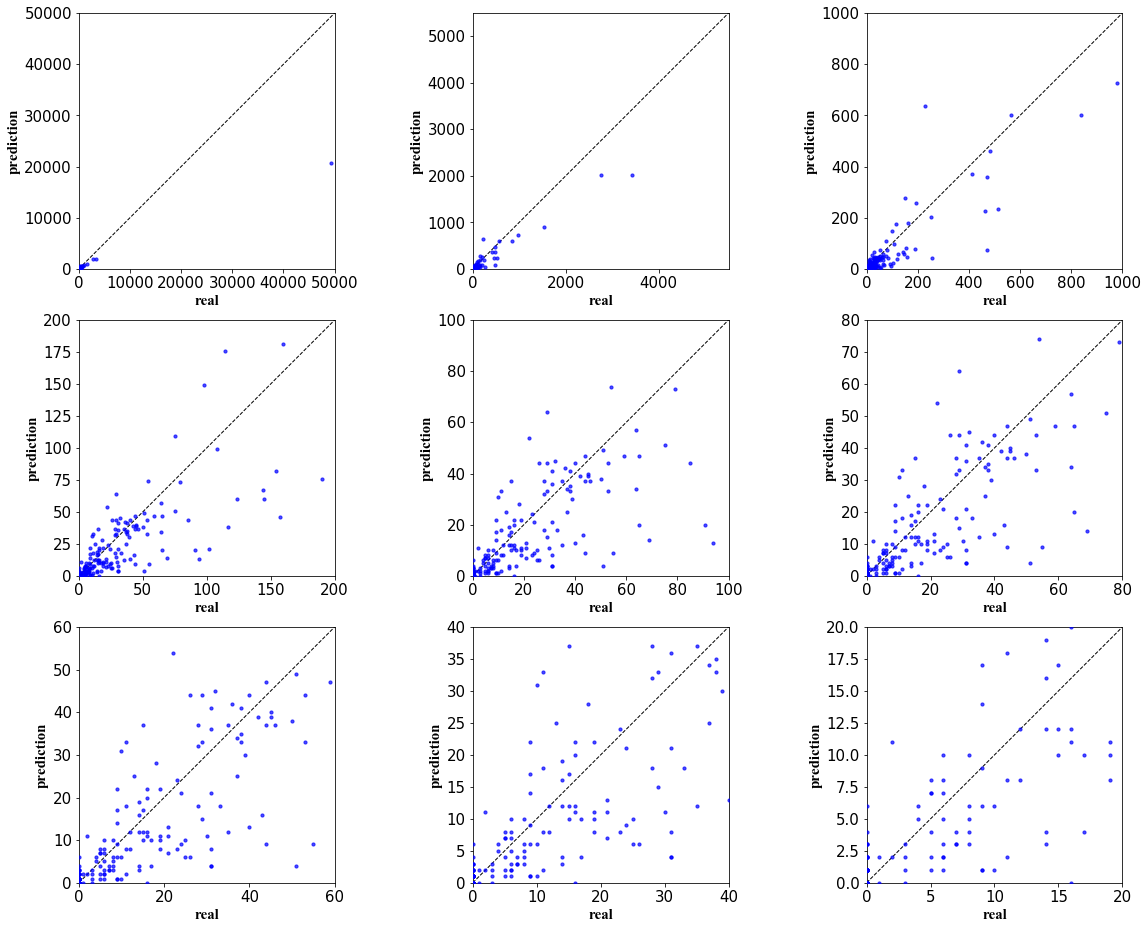

#########################################
test fold 3
预测误差较大城市，绝对值误差阈值设置为50
南京市   real: 86   pre:162.0
南昌市   real: 222   pre:137.0
新余市   real: 127   pre:2.0
宜春市   real: 100   pre:38.0
郑州市   real: 128   pre:367.0
南阳市   real: 137   pre:285.0
驻马店市   real: 130   pre:49.0
宜昌市   real: 900   pre:745.0
襄阳市   real: 1139   pre:745.0
鄂州市   real: 1374   pre:725.0
随州市   real: 1255   pre:462.0
长沙市   real: 220   pre:422.0
广州市   real: 396   pre:162.0
甘孜藏族自治州   real: 76   pre:0.0
R-squared 0.8224163291742691
R 0.906871726968191
mae 36.85
rmse 110.96606087748933


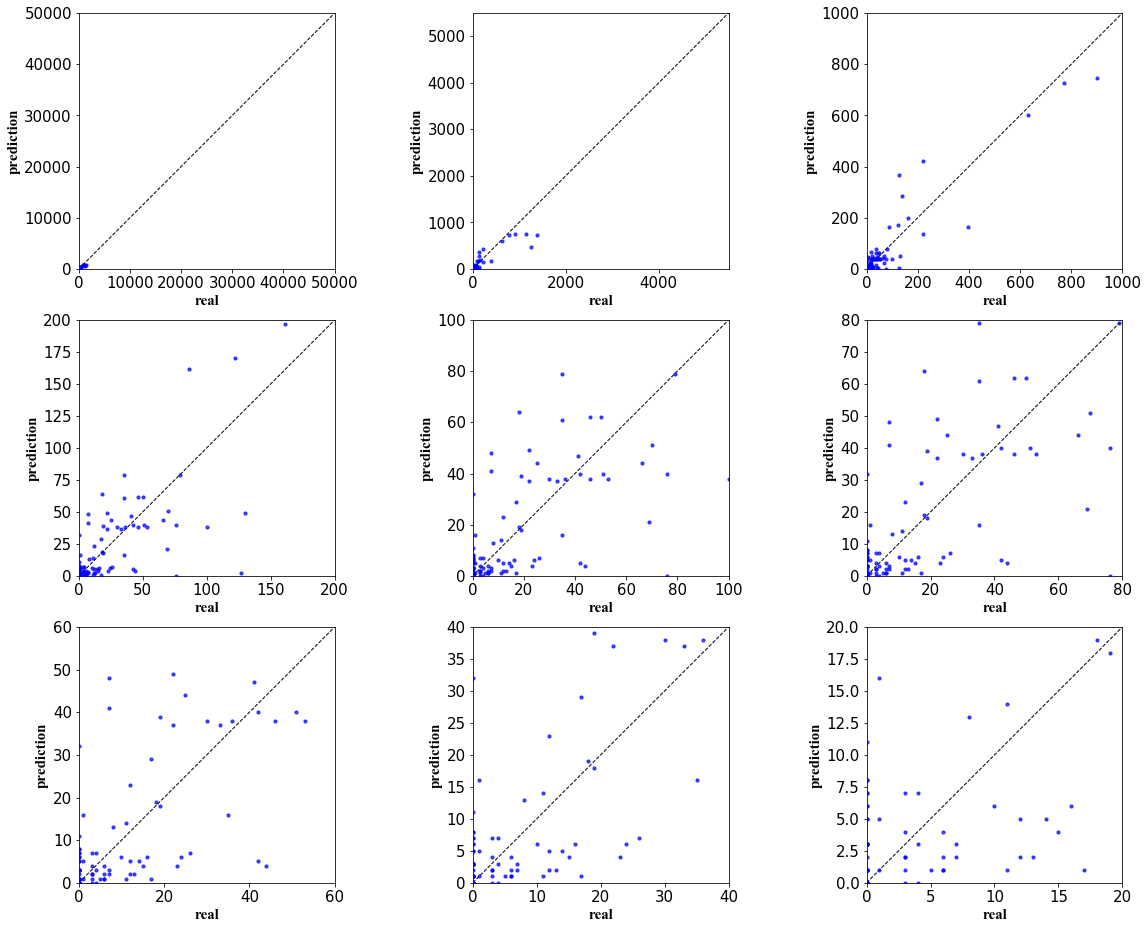

************* cv evaluation ***************
R-squared 0.06355433400643934
R 0.25209984927889056
mae 180.26869806094183
rmse 2570.264302457538


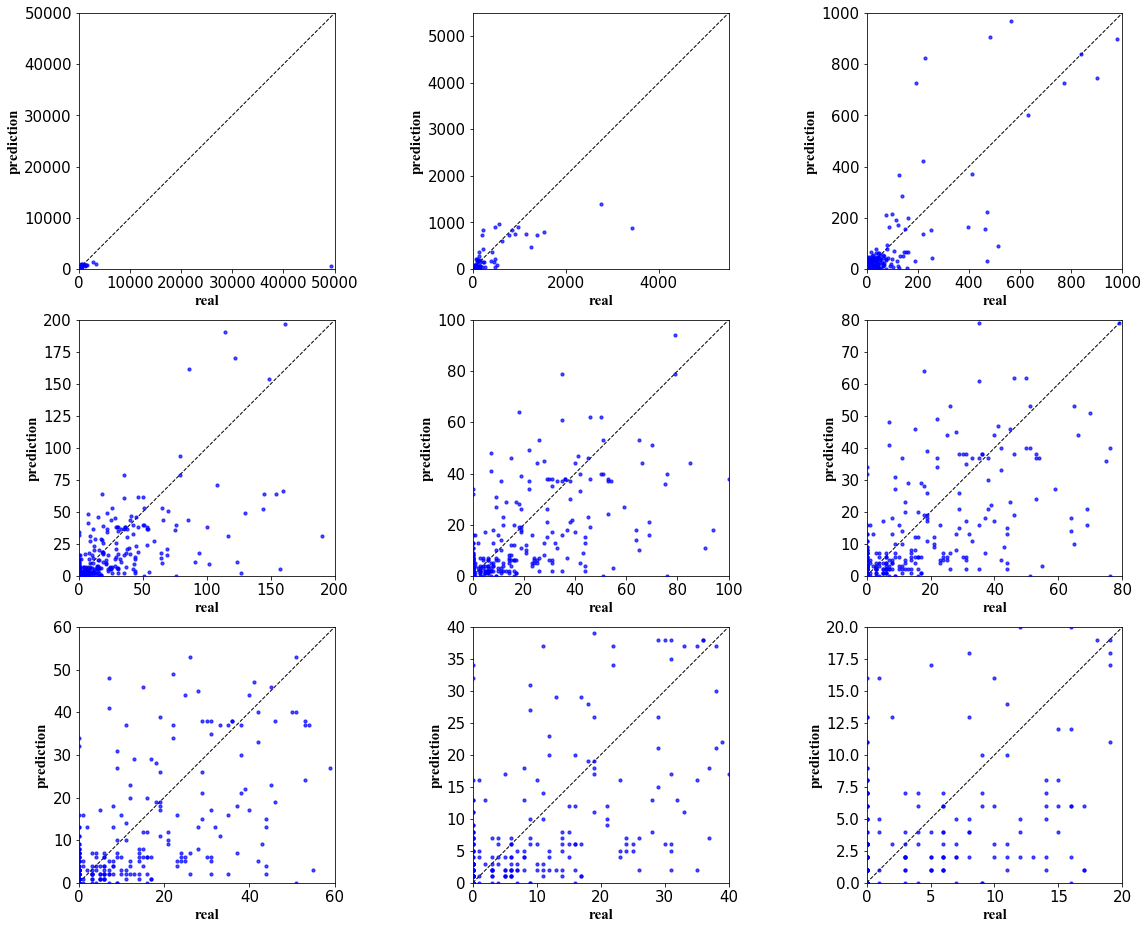

%%%%%% feature importances %%%%%%


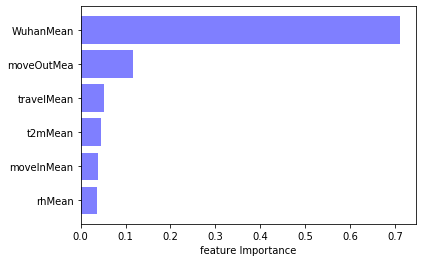

In [137]:
df = gp.GeoDataFrame.from_file("../shp/china_city_distinct_COVID19_after.shp")
    
kf = KFold(3, True)
index = []
for train_index, test_index in kf.split(df):
    index.append((train_index, test_index))

# 全时间段建模
#df = df[~df['id'].isin(epidemicIds)]
case, df_predict = covid_all_predict(df, index, threshold=50)

In [138]:
df = pd.merge(df, df_predict, how='inner', on='id')
df['diff'] = df['confirmed'] - df['predict']
df = df[df['id'].isin(case)]
df = df[['id','location','confirmed', 'predict',
    'rhMean',
    't2mMean',
    'moveInMean',
    'moveOutMea',
    'travelMean',
    'WuhanMean',
     'diff']]

In [ ]:
# 管控后预测过高和过低的情况与全时间段基本类似

In [139]:
df[df['diff']>0].sort_values(by='diff', ascending=False)

,id,location,confirmed,predict,rhMean,t2mMean,moveInMean,moveOutMea,travelMean,WuhanMean,diff
167,420100,武汉市,49308,597.0,67.548395,284.256138,0.542080,0.303700,0.764031,100.000000,48711.0
174,420900,孝感市,3418,880.0,67.495974,283.472206,0.175240,0.276545,2.293580,16.315077,2538.0
176,421100,黄冈市,2753,1391.0,70.135725,283.436388,0.190124,0.413585,2.800152,20.989077,1362.0
178,421300,随州市,1255,462.0,67.635691,282.872199,0.073377,0.132341,2.224703,1.853538,793.0
175,421000,荆州市,1533,803.0,69.231072,284.337159,0.237780,0.419148,2.643878,6.812923,730.0
172,420700,鄂州市,1374,725.0,68.977774,284.789154,0.080072,0.096943,1.504028,5.203231,649.0
88,330300,温州市,472,30.0,77.923209,284.666702,0.941910,0.587904,2.580782,0.042615,442.0
0,110000,北京市,512,89.0,46.468169,274.994719,2.871917,1.396534,2.533645,0.182154,423.0
171,420600,襄阳市,1139,745.0,67.982955,282.419131,0.180650,0.282184,2.327737,3.511538,394.0
72,310000,上海市,463,154.0,70.698488,283.184662,3.597767,1.888296,3.434394,0.299231,309.0


In [140]:
df[df['diff']<0].sort_values(by='diff', ascending=True)

,id,location,confirmed,predict,rhMean,t2mMean,moveInMean,moveOutMea,travelMean,WuhanMean,diff
179,422800,恩施土家族苗族自治州,227,825.0,78.710185,281.009652,0.157376,0.257877,3.280932,5.884308,-598.0
181,429005,潜江市,193,728.0,68.510573,284.159537,0.066477,0.086867,2.197575,1.019077,-535.0
182,429006,天门市,483,905.0,67.397417,283.935709,0.077401,0.139474,2.915722,2.029385,-422.0
180,429004,仙桃市,563,969.0,68.048552,284.140160,0.079986,0.113498,2.243594,3.041692,-406.0
149,410100,郑州市,128,367.0,54.497972,282.009780,2.365988,1.453476,2.633251,0.407385,-239.0
184,430100,长沙市,220,422.0,75.230205,284.888353,2.528474,1.823747,2.973386,0.542615,-202.0
161,411300,南阳市,137,285.0,62.697251,281.920763,0.401780,0.791422,3.071334,0.349231,-148.0
185,430200,株洲市,75,210.0,77.636058,285.841944,0.554582,0.612216,3.463406,0.298769,-135.0
214,441900,东莞市,98,215.0,73.799657,292.110542,4.424677,2.442916,2.284398,0.179231,-117.0
125,360400,九江市,114,191.0,75.150334,284.121798,0.328033,0.535635,3.361745,0.301692,-77.0


In [141]:
# 总结

# 预测过低的情况——实际确诊人数在50~600，预测人数严重偏低，均在100以下，甚至接近于0，这类城市的WuhanMean极低，接近于0

# 预测过高的情况——实际确诊人数在200以下，预测城市确诊人数严重偏高，均在300以上，甚至接近于1000，这类城市的WuhanMean较高

## 以上两种情况推测百度迁徙指数数据存在误差，比如温州；
## 很多城市与武汉没有直接联系，这类情况考虑补充与省会的迁徙，更好的表达方式或许还是图卷积
## 目前筛选的特征并不能完全表征城市，存在一些城市特征很接近，但是label差异较大，这类情况模型只能做折中处理，无法偏向任何一方

### 在计算cv的r2时，要不要把武汉去掉来计算，或者建模的时候把它扔掉？？？那样结果倒是好看很多😁